In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 데이터 로드
df = pd.read_csv('./final_20f_data.csv')
# datetime 열을 datetime 타입으로 변환
df['datetime'] = pd.to_datetime(df['datetime'])
# 연도와 월 파생 변수 생성
df['Pyear'] = df['datetime'].dt.year
df['Pmonth'] = df['datetime'].dt.month
##
df.drop(columns=['store_name','card_name','card_type','transaction_type'], inplace=True)
df.rename(columns={'category_name':'Bizcode'}, inplace=True)
df.rename(columns={'amount':'Price'}, inplace=True)

# 2024년 12월 데이터 분리
# train_data: 예측을 위해 사용할 훈련 데이터. 2024년 11월을 제외한 모든 데이터입니다.
# test_data: 모델 평가 및 예측 결과 비교에 사용할 테스트 데이터. 2024년 11월 데이터입니다.
train_data = df[~((df['Pyear'] == 2024) & (df['Pmonth'] == 11))]
test_data = df[(df['Pyear'] == 2024) & (df['Pmonth'] == 11)]

# 월별 Bizcode별 소비 금액 집계
# 연도(Pyear), 월(Pmonth), 카테고리(Bizcode) 기준으로 Price를 집계합니다.
# 소비 금액의 합계로 월별 데이터를 생성합니다.
monthly_train = train_data.groupby(['Pyear', 'Pmonth', 'Bizcode'])['Price'].sum().reset_index()
monthly_test = test_data.groupby(['Pyear', 'Pmonth', 'Bizcode'])['Price'].sum().reset_index()

# Pivot 변환
# pivot을 통해 행은 Pyear와 Pmonth, 열은 Bizcode, 값은 소비 금액(Price)으로 구성된 테이블로 변환합니다.
# 결측값(NaN)은 0으로 채웁니다.
train_pivot = monthly_train.pivot(index=['Pyear', 'Pmonth'], columns='Bizcode', values='Price').fillna(0)
test_pivot = monthly_test.pivot(index=['Pyear', 'Pmonth'], columns='Bizcode', values='Price').fillna(0)

# 2. TotalSpending 추가
# 행(Pyear, Pmonth)별 총 소비 금액을 계산하여 TotalSpending 열에 추가합니다.
train_pivot['TotalSpending'] = train_pivot.sum(axis=1)
test_pivot['TotalSpending'] = test_pivot.sum(axis=1)

# 3. Bizcode별 소비 비율 계산
# 각 Bizcode별 소비 비율을 계산합니다.
# 각 Bizcode 소비 금액을 TotalSpending으로 나누어 비율(ratio)로 변환합니다.
# 결측값은 0으로 처리합니다.
train_pivot_ratio = train_pivot.div(train_pivot['TotalSpending'], axis=0).fillna(0)
test_pivot_ratio = test_pivot.div(test_pivot['TotalSpending'], axis=0).fillna(0)
# TotalSpending를 비율 데이터에 다시 추가
train_pivot_ratio['TotalSpending'] = train_pivot['TotalSpending']
test_pivot_ratio['TotalSpending'] = test_pivot['TotalSpending']



# 4. TotalSpending 예측 모델 학습
# 독립 변수(X)는 Bizcode별 소비 비율이고, 종속 변수(y)는 TotalSpending입니다.
# 데이터를 훈련 데이터와 검증 데이터로 분리하여 성능 평가를 위한 검증 데이터 준비.
# RandomForestRegressor 모델을 학습하고, 검증 데이터의 MAE(평균 절대 오차)를 출력하여 모델의 성능을 확인합니다.
X = train_pivot_ratio.drop(columns=['TotalSpending']).reset_index(drop=True)
y = train_pivot_ratio['TotalSpending'].reset_index(drop=True)

# 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
# 검증 데이터 평가
y_val_pred = model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
# 실제랑 예측이랑 차이
print(f"검증 데이터 MAE: {val_mae:.2f}")


# 5. 테스트 데이터에서 TotalSpending 예측
X_test = test_pivot_ratio.drop(columns=['TotalSpending']).reset_index(drop=True)
y_test_pred = model.predict(X_test)

# 6. Bizcode별 소비 금액 계산
# 예측한 TotalSpending과 Bizcode 소비 비율을 곱하여 Bizcode별 소비 금액을 계산합니다.
predicted_ratios = test_pivot_ratio.drop(columns=['TotalSpending']).values
predicted_category_spending = y_test_pred[:, None] * predicted_ratios

# 결과를 데이터프레임으로 변환
# 예측한 Bizcode별 소비 금액을 데이터프레임으로 변환.
# predicted_total 열에 예측한 TotalSpending을 추가.
predicted_category_df = pd.DataFrame(
    predicted_category_spending,
    columns=test_pivot_ratio.columns.drop('TotalSpending'),
    index=test_pivot_ratio.index
)

# TotalSpending 추가
predicted_category_df['predicted_total'] = y_test_pred


# 7. 결과 확인
# Bizcode별 실제 소비 금액(actual)과 예측 소비 금액(predicted)을 출력합니다.
# TotalSpending의 실제값과 예측값을 비교합니다.
print("Bizcode별 소비 금액 예측 결과:")
for category in test_pivot_ratio.columns.drop('TotalSpending'):
    actual = test_pivot_ratio.loc[:, category].values[0] * test_pivot_ratio.loc[:, 'TotalSpending'].values[0]
    predicted = predicted_category_df.loc[:, category].values[0]
    print(f"{category} - 실제값: {actual:,.0f}, 예측값: {predicted:,.0f}")

# TotalSpending 비교
actual_total = test_pivot_ratio['TotalSpending'].values[0]
predicted_total = predicted_category_df['predicted_total'].values[0]
print(f"TotalSpending - 실제값: {actual_total:,.0f}, 예측값: {predicted_total:,.0f}")

# 실제 소비 데이터와 예측값을 비교하면서, 월별 소비 금액과 소비 비율의 패턴을 분석하고 예측하는 과정

검증 데이터 MAE: 18228.67
Bizcode별 소비 금액 예측 결과:
교육/육아 - 실제값: 51,800, 예측값: 51,223
교통(대중) - 실제값: 55,000, 예측값: 54,387
기타 - 실제값: 233,700, 예측값: 231,097
마트 - 실제값: 161,300, 예측값: 159,504
병원/약국 - 실제값: 35,200, 예측값: 34,808
쇼핑 - 실제값: 381,900, 예측값: 377,647
여행/숙박 - 실제값: 133,000, 예측값: 131,519
영화/문화 - 실제값: 154,800, 예측값: 153,076
외식 - 실제값: 245,000, 예측값: 242,272
자동차/하이패스 - 실제값: 24,400, 예측값: 24,128
주유 - 실제값: 105,200, 예측값: 104,028
카페/디저트 - 실제값: 255,400, 예측값: 252,556
통신 - 실제값: 50,000, 예측값: 49,443
편의점 - 실제값: 107,800, 예측값: 106,599
TotalSpending - 실제값: 1,994,500, 예측값: 1,972,288


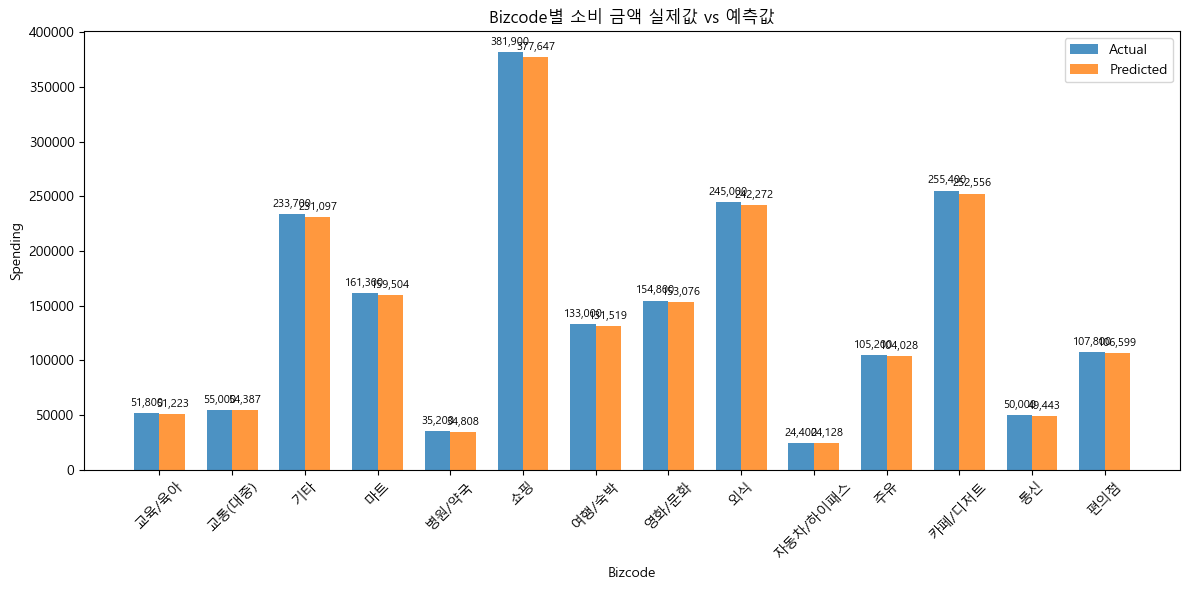

In [12]:

import matplotlib.pyplot as plt
import numpy as np

# Bizcode별 실제값과 예측값 비교 바 그래프
categories = test_pivot_ratio.columns.drop('TotalSpending')
actual_values = [test_pivot_ratio.loc[:, category].values[0] * test_pivot_ratio.loc[:, 'TotalSpending'].values[0] for category in categories]
predicted_values = [predicted_category_df.loc[:, category].values[0] for category in categories]

x = np.arange(len(categories))  # 카테고리 인덱스
width = 0.35  # 바 너비

fig, ax = plt.subplots(figsize=(12, 6))
bars_actual = ax.bar(x - width/2, actual_values, width, label='Actual', alpha=0.8)
bars_predicted = ax.bar(x + width/2, predicted_values, width, label='Predicted', alpha=0.8)

# 레이블 및 제목 설정
ax.set_xlabel('Bizcode')
ax.set_ylabel('Spending')
ax.set_title('Bizcode별 소비 금액 실제값 vs 예측값')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

# 값 표시
for bar in bars_actual:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

for bar in bars_predicted:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()



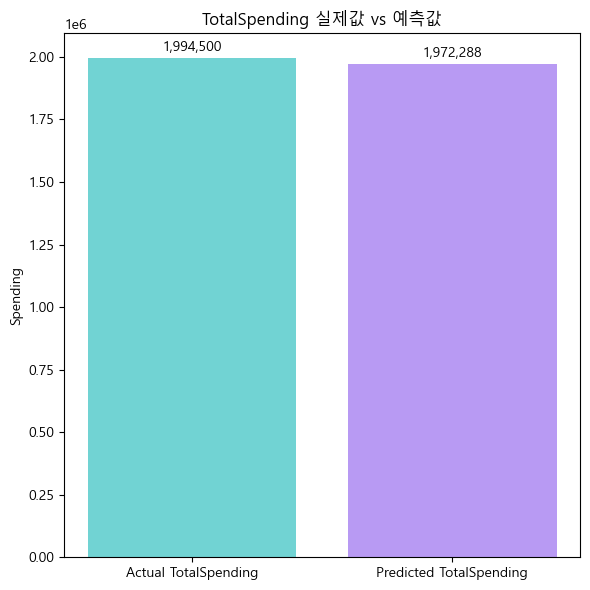

In [16]:
# TotalSpending 실제값과 예측값 비교
actual_total = test_pivot_ratio['TotalSpending'].values[0]
predicted_total = predicted_category_df['predicted_total'].values[0]

fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(
    ['Actual TotalSpending', 'Predicted TotalSpending'], 
    [actual_total, predicted_total], 
    color=['#4dc9c9', '#a681f0'], 
    alpha=0.8
)

# 레이블 추가
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# 제목 설정
ax.set_title('TotalSpending 실제값 vs 예측값')
ax.set_ylabel('Spending')

plt.tight_layout()
plt.show()

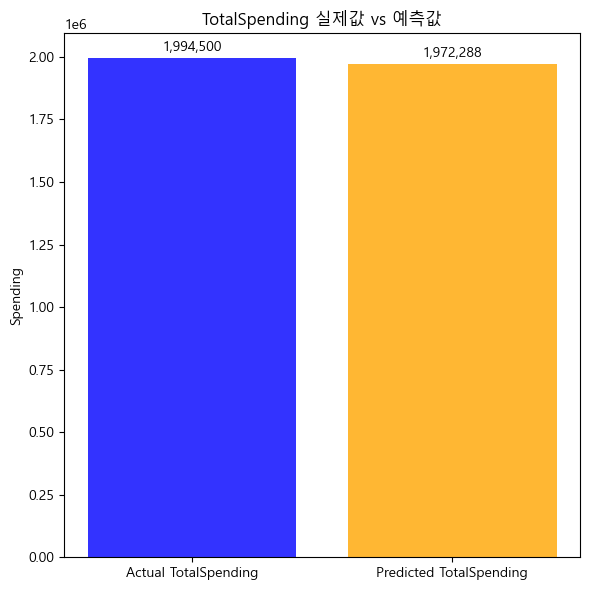

In [13]:
# TotalSpending 실제값과 예측값 비교
actual_total = test_pivot_ratio['TotalSpending'].values[0]
predicted_total = predicted_category_df['predicted_total'].values[0]

fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(['Actual TotalSpending', 'Predicted TotalSpending'], [actual_total, predicted_total], color=['blue', 'orange'], alpha=0.8)

# 레이블 추가
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# 제목 설정
ax.set_title('TotalSpending 실제값 vs 예측값')
ax.set_ylabel('Spending')

plt.tight_layout()
plt.show()

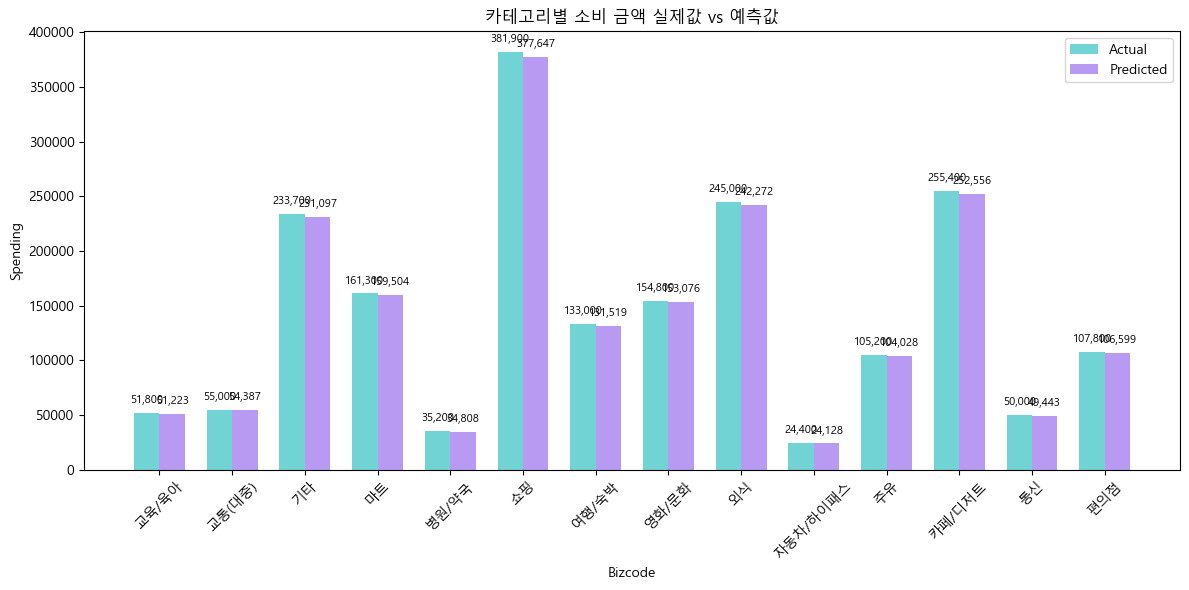

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정 (예: 'Malgun Gothic')
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# Bizcode별 실제값과 예측값 비교 바 그래프
categories = test_pivot_ratio.columns.drop('TotalSpending')
actual_values = [test_pivot_ratio.loc[:, category].values[0] * test_pivot_ratio.loc[:, 'TotalSpending'].values[0] for category in categories]
predicted_values = [predicted_category_df.loc[:, category].values[0] for category in categories]

x = np.arange(len(categories))  # 카테고리 인덱스
width = 0.35  # 바 너비

fig, ax = plt.subplots(figsize=(12, 6))
bars_actual = ax.bar(x - width/2, actual_values, width, label='Actual', color='#4dc9c9', alpha=0.8)
bars_predicted = ax.bar(x + width/2, predicted_values, width, label='Predicted', color='#a681f0', alpha=0.8)

# 레이블 및 제목 설정
ax.set_xlabel('Bizcode')
ax.set_ylabel('Spending')
ax.set_title('카테고리별 소비 금액 실제값 vs 예측값')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

# 값 표시 - 값을 위로 올려 겹치지 않게 조정
for bar in bars_actual:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=8)

for bar in bars_predicted:
    height = bar.get_height()
    ax.annotate(f'{height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from tabulate import tabulate  # 보기 좋은 표 출력을 위해

# 데이터 로드
df = pd.read_csv('./final_20f_data.csv')
# datetime 열을 datetime 타입으로 변환
df['datetime'] = pd.to_datetime(df['datetime'])

# 연도와 월 파생 변수 생성
df['Pyear'] = df['datetime'].dt.year
df['Pmonth'] = df['datetime'].dt.month

# 불필요한 열 삭제 및 열 이름 변경
df.drop(columns=['store_name', 'card_name', 'card_type', 'transaction_type'], inplace=True)
df.rename(columns={'category_name': 'Bizcode', 'amount': 'Price'}, inplace=True)

# 2024년 12월 데이터 분리
train_data = df[~((df['Pyear'] == 2024) & (df['Pmonth'] == 11))]
test_data = df[(df['Pyear'] == 2024) & (df['Pmonth'] == 11)]

# 월별 Bizcode별 소비 금액 집계
monthly_train = train_data.groupby(['Pyear', 'Pmonth', 'Bizcode'])['Price'].sum().reset_index()
monthly_test = test_data.groupby(['Pyear', 'Pmonth', 'Bizcode'])['Price'].sum().reset_index()

# Pivot 변환
train_pivot = monthly_train.pivot(index=['Pyear', 'Pmonth'], columns='Bizcode', values='Price').fillna(0)
test_pivot = monthly_test.pivot(index=['Pyear', 'Pmonth'], columns='Bizcode', values='Price').fillna(0)

# TotalSpending 추가
train_pivot['TotalSpending'] = train_pivot.sum(axis=1)
test_pivot['TotalSpending'] = test_pivot.sum(axis=1)

# Bizcode별 소비 비율 계산
train_pivot_ratio = train_pivot.div(train_pivot['TotalSpending'], axis=0).fillna(0)
test_pivot_ratio = test_pivot.div(test_pivot['TotalSpending'], axis=0).fillna(0)
# TotalSpending를 비율 데이터에 다시 추가
train_pivot_ratio['TotalSpending'] = train_pivot['TotalSpending']
test_pivot_ratio['TotalSpending'] = test_pivot['TotalSpending']

# TotalSpending 예측 모델 학습
# X는 각 행별로 특정 Bizcode(카테고리)별 소비 비율을 나타냅니다. -> 독립변수
# TotalSpending을 기준으로 각 Bizcode의 소비 비율을 계산한 값입니다.
# 즉, 입력 데이터로 모델이 TotalSpending을 예측하기 위해 사용하는 데이터입니다.
X = train_pivot_ratio.drop(columns=['TotalSpending']).reset_index(drop=True)

# y는 각 연도와 월별로 기록된 실제 TotalSpending 값(총 소비 금액)입니다. -> 종속변수
# 이는 모델이 예측해야 하는 대상 값입니다.
y = train_pivot_ratio['TotalSpending'].reset_index(drop=True)

# => 입력 X(Bizcode별 소비 비율)를 바탕으로 총 소비 금액 y(TotalSpending)를 예측합니다.

# 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 검증 데이터 평가
y_val_pred = model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"검증 데이터 MAE: {val_mae:.2f}")

# 테스트 데이터에서 TotalSpending 예측
X_test = test_pivot_ratio.drop(columns=['TotalSpending']).reset_index(drop=True)
y_test_pred = model.predict(X_test)

# Bizcode별 소비 금액 계산
predicted_ratios = test_pivot_ratio.drop(columns=['TotalSpending']).values
predicted_category_spending = y_test_pred[:, None] * predicted_ratios

# 결과를 데이터프레임으로 변환
predicted_category_df = pd.DataFrame(
    predicted_category_spending,
    columns=test_pivot_ratio.columns.drop('TotalSpending'),
    index=test_pivot_ratio.index
)

# TotalSpending 추가
predicted_category_df['predicted_total'] = y_test_pred

# 결과 확인
# Bizcode별 실제값과 예측값 비교 데이터프레임 생성
result_data = []
for category in test_pivot_ratio.columns.drop('TotalSpending'):
    actual = test_pivot_ratio.loc[:, category].values[0] * test_pivot_ratio.loc[:, 'TotalSpending'].values[0]
    predicted = predicted_category_df.loc[:, category].values[0]
    result_data.append([category, f"{actual:,.0f}", f"{predicted:,.0f}"])

# TotalSpending 비교 추가
actual_total = test_pivot_ratio['TotalSpending'].values[0]
predicted_total = predicted_category_df['predicted_total'].values[0]
result_data.append(["TotalSpending", f"{actual_total:,.0f}", f"{predicted_total:,.0f}"])

# 데이터프레임으로 변환
result_df = pd.DataFrame(result_data, columns=['Bizcode', 'Actual Spending', 'Predicted Spending'])

# 표 형식으로 출력
print("Prediction Results:")
print(tabulate(result_df, headers='keys', tablefmt='pretty'))

검증 데이터 MAE: 18228.67
Prediction Results:
+----+-----------------+-----------------+--------------------+
|    |     Bizcode     | Actual Spending | Predicted Spending |
+----+-----------------+-----------------+--------------------+
| 0  |    교육/육아    |     51,800      |       51,223       |
| 1  |   교통(대중)    |     55,000      |       54,387       |
| 2  |      기타       |     233,700     |      231,097       |
| 3  |      마트       |     161,300     |      159,504       |
| 4  |    병원/약국    |     35,200      |       34,808       |
| 5  |      쇼핑       |     381,900     |      377,647       |
| 6  |    여행/숙박    |     133,000     |      131,519       |
| 7  |    영화/문화    |     154,800     |      153,076       |
| 8  |      외식       |     245,000     |      242,272       |
| 9  | 자동차/하이패스 |     24,400      |       24,128       |
| 10 |      주유       |     105,200     |      104,028       |
| 11 |   카페/디저트   |     255,400     |      252,556       |
| 12 |      통신       |     50,000      | 